# Initial Data cleaning and organizing

###### I made signifcant formatting changes to each data file in excel before importing them into python for further analysis.

In [3]:
#import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [4]:
#import csv files
amtrak_ridership_by_station= pd.read_csv('amtrak_ridership_by_station.csv')
amtrak_route_details= pd.read_csv('amtrak_route_details.csv')

fy17_otp=pd.read_excel('FY17_otp.xlsx')
fy18_otp=pd.read_excel('FY18_otp.xlsx')
fy19_otp=pd.read_excel('FY19_otp.xlsx')
fy20_otp=pd.read_excel('FY20_otp.xlsx')
fy21_otp=pd.read_excel('FY21_otp.xlsx')
fy22_otp=pd.read_excel('FY22_otp.xlsx')
fy23_otp=pd.read_excel('FY23_otp.xlsx')

fy17_ridership_by_route=pd.read_excel('FY17_ridership_by_route.xlsx')
fy18_ridership_by_route=pd.read_excel('FY18_ridership_by_route.xlsx')
fy19_ridership_by_route=pd.read_excel('FY19_ridership_by_route.xlsx')
fy20_ridership_by_route=pd.read_excel('FY20_ridership_by_route.xlsx')
fy21_ridership_by_route=pd.read_excel('FY21_ridership_by_route.xlsx')
fy22_ridership_by_route=pd.read_excel('FY22_ridership_by_route.xlsx')
fy23_ridership_by_route=pd.read_excel('FY23_ridership_by_route.xlsx')

fy_roundtrips =pd.read_excel('fy_roundtrips.xlsx')

In [5]:
#fix fy18_otp percent values
fy18_otp = fy18_otp[['system','route_name','customer_otp','endpoint_otp','all_stations_otp','ave_customer_otp_by_system',
'ave_endpoint_otp_by_system', 'ave_all_stations_otp_by_system']] 

#add a year column to each dataset        # leave out fy17_ridership_by_route because of difference in column data
dfs = [(fy17_otp, 2017),(fy18_otp, 2018),(fy19_otp, 2019),(fy20_otp, 2020),(fy21_otp, 2021),(fy22_otp, 2022),(fy23_otp, 2023),
       (fy18_ridership_by_route, 2018), (fy19_ridership_by_route, 2019), (fy20_ridership_by_route, 2020),
      (fy21_ridership_by_route, 2021), (fy22_ridership_by_route, 2022), (fy23_ridership_by_route, 2023)]

for df, year in dfs:
    df['year'] = year

In [6]:
#merge corresponding datasets
fy_otp = [fy17_otp, fy18_otp, fy19_otp, fy20_otp, fy21_otp, fy22_otp, fy23_otp]
fy_otp = pd.concat(fy_otp,ignore_index=True, sort=True)

fy_ridership = [fy18_ridership_by_route, fy19_ridership_by_route, fy20_ridership_by_route, fy21_ridership_by_route, 
                fy22_ridership_by_route, fy23_ridership_by_route]
fy_ridership = pd.concat(fy_ridership,ignore_index=True, sort=True)

In [7]:
#drop unnessecary columns 
fy_ridership.drop('Unnamed: 16', axis=1,inplace=True)
fy_ridership.drop('Unnamed: 17', axis=1,inplace=True)

In [8]:
# drop unnessecary columns 
fy_otp = fy_otp[["year", "system","route_name", "customer_otp", "endpoint_otp", "all_stations_otp", "ave_all_stations_otp_by_system",
                 "ave_customer_otp_by_system", "ave_endpoint_otp_by_system"]]

In [9]:
#clean up roundtrip text
#create function to remove any string values and change values in terms of number of daily trips
def clean_value(value):
    if isinstance(value, str):  # Check if the entry is a string
        if value.endswith(" RT daily"):
            return int(value.split()[0])
        elif value.endswith(" RTs daily"):
            return int(value.split()[0]) 
        elif value.endswith(" RT daily (planned)"):
            return int(value.split()[0]) 
        elif value.endswith(" RTs daily\n(SEA-PDX core)"):
            return int(value.split()[0])
        # Keep only the number
        elif value.endswith(" RTs weekly"):
            return int(value.split()[0]) / 7  # Divide the number by 7
    return value  # Leave it unchanged if it doesn't match the patterns
	

# Apply the function to the columns
fy_roundtrips['ave_weekday_rt_30_sept_2020'] = fy_roundtrips['ave_weekday_rt_30_sept_2020'].apply(clean_value)
fy_roundtrips['ave_weekday_rt_30_sept_2021'] = fy_roundtrips['ave_weekday_rt_30_sept_2021'].apply(clean_value)
fy_roundtrips['ave_weekday_rt_30_sept_2022'] = fy_roundtrips['ave_weekday_rt_30_sept_2022'].apply(clean_value)
fy_roundtrips['ave_weekday_rt_30_sept_2023'] = fy_roundtrips['ave_weekday_rt_30_sept_2023'].apply(clean_value)

#change any other text 
fy_roundtrips = fy_roundtrips.replace('suspended', 0)
fy_roundtrips['ave_weekday_rt_30_sept_2020']= fy_roundtrips['ave_weekday_rt_30_sept_2020'].replace('see Hartford Line', 4) 
fy_roundtrips['ave_weekday_rt_30_sept_2021']= fy_roundtrips['ave_weekday_rt_30_sept_2021'].replace('see Hartford Line', 7) 
fy_roundtrips['ave_weekday_rt_30_sept_2022']= fy_roundtrips['ave_weekday_rt_30_sept_2022'].replace('see Hartford Line', 7)
fy_roundtrips['ave_weekday_rt_30_sept_2023']= fy_roundtrips['ave_weekday_rt_30_sept_2023'].replace('see Hartford Line', 6) 
fy_roundtrips = fy_roundtrips.replace("NaN",0)
#make the decision to only mark trips that are seasonal and not year round to 0 for a year round comparison
fy_roundtrips = fy_roundtrips.replace("3 RTs weekly\n(winter only)",0)
fy_roundtrips = fy_roundtrips.replace("1 RT weekly\n(summer only)",0)

# 1. What routes are "similar" to each other? What makes them "similar" to one-another? 

#### Investigating fy_otp for similarities in data

In [12]:
#investigating correlation between on time performance metrics
num = fy_otp[["customer_otp",'endpoint_otp','all_stations_otp','ave_all_stations_otp_by_system',
              'ave_customer_otp_by_system', 'ave_endpoint_otp_by_system']]
correlation_matrix = num.corr()
correlation_matrix

,customer_otp,endpoint_otp,all_stations_otp,ave_all_stations_otp_by_system,ave_customer_otp_by_system,ave_endpoint_otp_by_system
customer_otp,1.000000,0.925101,0.951533,0.716892,0.720455,0.708423
endpoint_otp,0.925101,1.000000,0.872862,0.618305,0.624817,0.591986
all_stations_otp,0.951533,0.872862,1.000000,0.780433,0.781756,0.705598
ave_all_stations_otp_by_system,0.716892,0.618305,0.780433,1.000000,0.992833,0.899292
ave_customer_otp_by_system,0.720455,0.624817,0.781756,0.992833,1.000000,0.981627
ave_endpoint_otp_by_system,0.708423,0.591986,0.705598,0.899292,0.981627,1.000000


#### The correlation matrix between Customer On Time Perfomance, Endpoint On Time Performance, All Stations End Time Performance, and averages of each of those variables, shows that they all share high correlations between eachother. If you knew a route's on time performance for one variable, you could most likely estimate the others

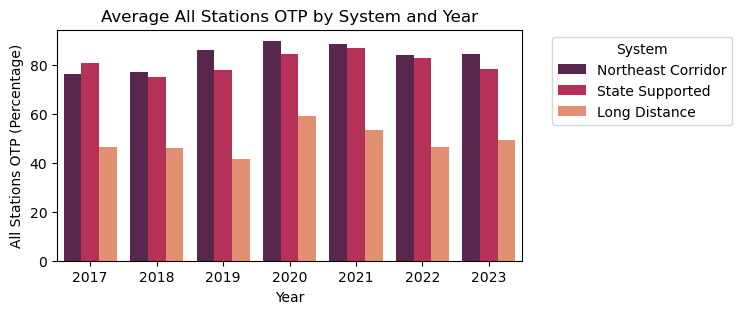

In [14]:
#further visualization of fy_otp consistancy throughout years
plt.figure(figsize=(6, 3))
sns.barplot(data=fy_otp, x='year', y='ave_all_stations_otp_by_system', hue='system', ci=None, palette='rocket')

plt.title('Average All Stations OTP by System and Year')
plt.xlabel('Year')
plt.ylabel('All Stations OTP (Percentage)')
plt.legend(title='System', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#### We can see that stations share similarities of on time performance within the past six years. On time performance measurements are highly correlated and its reasonable to assume that if all stations on time performance is high, endpoint and customer on time performance will also be high. 

#### Investigating fy_ridership for similarities in data

##### Because 2017 almost no columns similar with years 2018 through 2023, I chose to drop the year from the dataset when looking though a dimension reduction perspective. This was the best way to address NA values and missing data because imputation would not be genuine data. 

In [18]:
#Deal with missing values
#drop columns where more than 80% of the values are Na
fy_ridership = fy_ridership.drop(columns=['fully_allocated_profit_per_passenger_mile', 
                                          'ave_fully_allocated_profit_per_passenger_mile_by_system',
                                         'ave_revenue_to_cost_by_system'])

#drop 4 columns with missing values for 48 rows. Work with these columns in other aspects
fy_ridership = fy_ridership.drop(columns=['ave_short_term_avoidable_profit_per_passenger_by_system',
                                          'ave_state_funding_percent',
                                          'short_term_avoidable_profit_per_passenger',
                                         'state_funding_percent_of_operating_sources'])

#### Dimension Reduction

In [20]:
#standardize variables
#pull out quantitative variables
quant = fy_ridership[["adjusted_allocated_operating_sources","adjusted_allocated_operating_uses",
                     'passenger_miles','revenue_to_cost_ratio', 'ridership']]
#not going in scaler
categ = fy_ridership[["year","system"]]

scaled_data = StandardScaler().fit_transform(quant)
# Converting the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=("adjusted_allocated_operating_sources","adjusted_allocated_operating_uses", 
                                 'passenger_miles','revenue_to_cost_ratio', 'ridership'))

fy_ridership_scaled = pd.concat([categ, scaled_df], axis=1)

In [21]:
pca = PCA(n_components=2).fit(scaled_df)

# Convert the result to a DataFrame for easy interpretation
ridership_pca = pd.DataFrame(pca.transform(scaled_df), columns=['PCA1','PCA2'])

#add in categorical variables for visualizing
categ = categ.reset_index(drop=True)
ridership_pca = ridership_pca.reset_index(drop=True)

pca_ridership = pd.concat([categ, ridership_pca], axis=1)

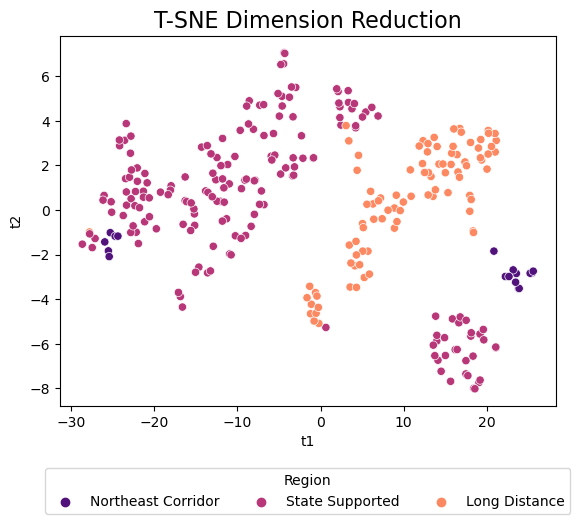

In [22]:
fy_ridership_scaled[['t1', 't2']] = TSNE(n_components=2,init='pca', perplexity=30.0).fit_transform(scaled_df)

sns.scatterplot(data=fy_ridership_scaled, x='t1', y='t2', hue='system', palette='magma')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.legend(title='Region', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=4)

plt.title("T-SNE Dimension Reduction", fontsize=16)
plt.show()

#### This T-SNE data reduction technique utilizing adjusted allocated operating source, adjusted allocated operating uses, passenger miles, revenue to cost ratio, and ridership for years 2018 through 2023 shows distinct groupings that indicate similarities in routes. When coloring these points by system type Northeast Corridor routes seem to cluster together, along with State Supported routes and long distance routes. We can see that routes of similar system groupings are similar to one another, especially knowing that T-SNE was not given these designations. 

# 2. How were routes impacted by COVID? Did some suffer more than others? Did some routes recover better than others? 

#### Looking into ridership data

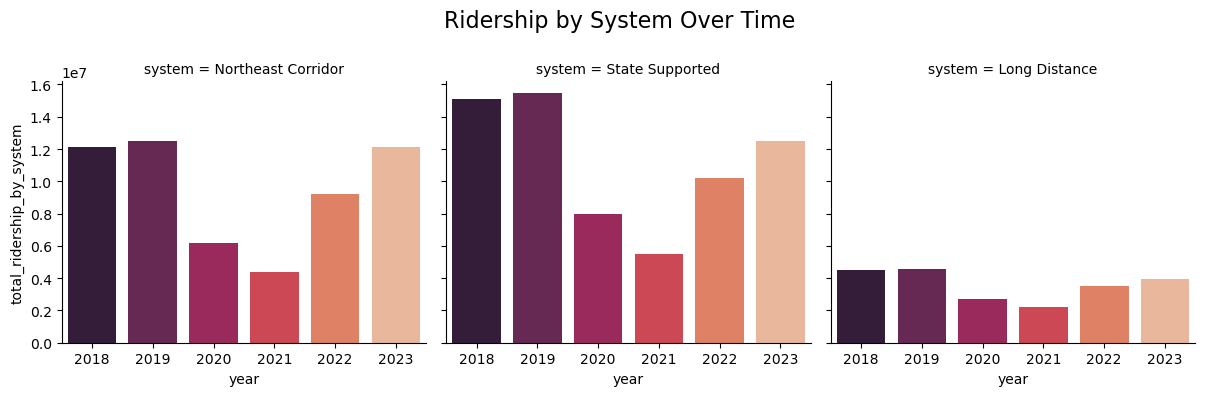

In [26]:
#What about ridership? 
fy_ridership_bar = fy_ridership[['year','system',"ave_revenue_to_cost_ratio_by_system","total_adjusted_allocated_operating_sources_by_system",
                                 'total_adjusted_allocated_operating_uses_by_system', 'total_passenger_mi_by_system',
                                 'total_ridership_by_system']].drop_duplicates()

p =sns.catplot(fy_ridership_bar, x="year", y="total_ridership_by_system", 
            col="system", kind="bar", col_wrap=4, height=4, palette='rocket')
p.fig.suptitle("Ridership by System Over Time", fontsize=16, ha='right')
p.fig.subplots_adjust(top=.8)

plt.show()

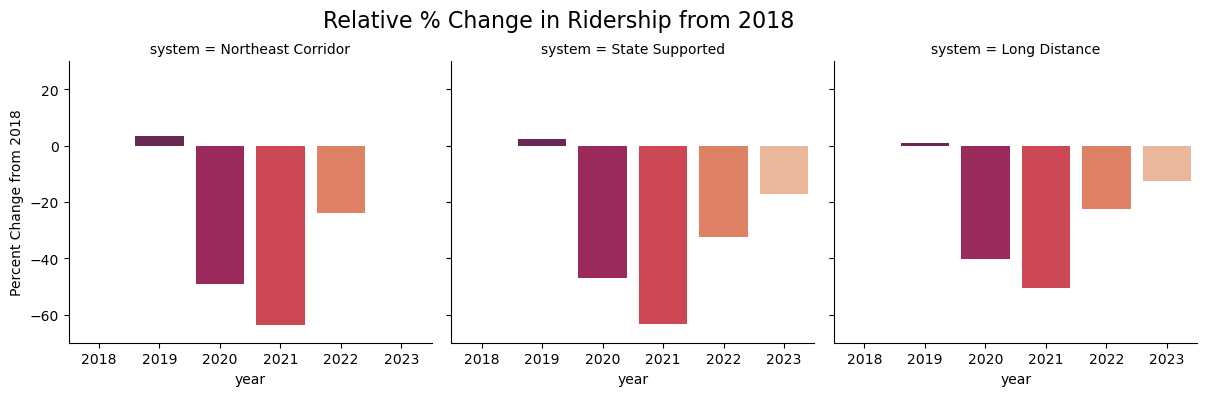

In [27]:
# Step 1: Calculate percentage change from 2018 for each system
fy_ridership_bar['pct_change_from_2018'] = (
    fy_ridership_bar.groupby('system')['total_ridership_by_system']
    .transform(lambda x: (x / x[x.index[0]] - 1) * 100)  # Calculate % change
)

# Step 2: Create the plot with percentage change
p = sns.catplot(data=fy_ridership_bar, x="year", y="pct_change_from_2018", 
                col="system", kind="bar", col_wrap=4, height=4, palette='rocket')

#Add title and adjust layout
p.fig.suptitle("Relative % Change in Ridership from 2018", fontsize=16, ha='right')
p.fig.subplots_adjust(top=0.85)  # Adjust top to fit title
p.set_ylabels("Percent Change from 2018")

# Set the y-axis limits
p.set(ylim=(-70, 30))

plt.show()

#### We can see that for Northeast Corridor routes, State Supported routes, and Long Distance routes, a significant dip / percentage drop in ridership occured in years 2020 and 2021. This is most likely due to the outbreak of Covid-19 and peoples choice not to travel and to quarantine. Northeast Corridor routes and State Supported routes seem to have been impacted the most with the most, with large dips between 2019 and 2020. It seems that each system has had an increase in routes following 2021, but only Northeast Corridor routes have reached recovery back to the level of ridership in 2018. 

# 3. Is Amtrak becoming more or less reliable as a method of transportation?

#### Exploring on time performance

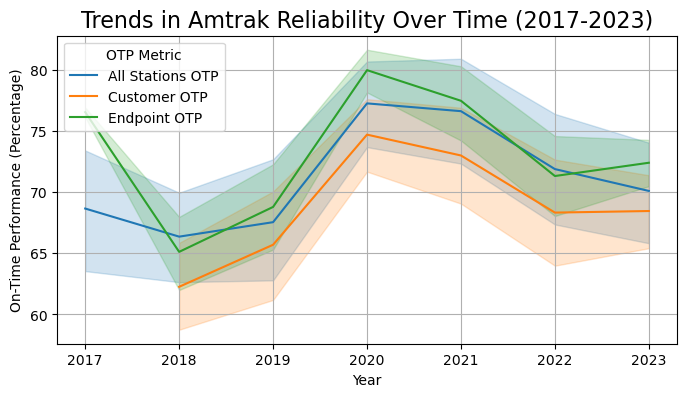

In [31]:
plt.figure(figsize=(8, 4))
sns.lineplot(data=fy_otp, x='year', y='ave_all_stations_otp_by_system', label='All Stations OTP')
sns.lineplot(data=fy_otp, x='year', y='ave_customer_otp_by_system', label='Customer OTP')
sns.lineplot(data=fy_otp, x='year', y='ave_endpoint_otp_by_system', label='Endpoint OTP')

plt.title('Trends in Amtrak Reliability Over Time (2017-2023)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('On-Time Performance (Percentage)')
plt.legend(title='OTP Metric', loc='upper left')
plt.grid(True)
plt.show()

#### Generally over time the on time performance was best during 2020, the peak year of covid. This is most likely because of the decline in overall routes being taken due to quarantine, and the need for on time trains so they can be cleaned before their next departures. Despite covid, routes have gotten more consistant from 2018 to 2023, and most on time performance metricts seem to be heading upwards. 

# 4. How has ridership changed across different states in different years? How is Amtrak meeting (or failing to meet) this demand with regular daily trips? 

#### investigate ridership by station which includes state designations

In [35]:
#change state info to state abbreviations
state_abbrev = {'Alabama': 'AL','Alaska': 'AK','Arizona': 'AZ','Arkansas': 'AR','California': 'CA','Colorado': 'CO','Connecticut': 'CT',
'Delaware': 'DE','Florida': 'FL','Georgia': 'GA','Hawaii': 'HI','Idaho': 'ID','Illinois': 'IL','Indiana': 'IN','Iowa': 'IA','Kansas': 'KS','Kentucky': 'KY',
'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO',
'Montana': 'MT','Nebraska': 'NE','Nevada': 'NV','New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC',
'North Dakota': 'ND','Ohio': 'OH','Oklahoma': 'OK','Oregon': 'OR','Pennsylvania': 'PA','Rhode Island': 'RI','South Carolina': 'SC','South Dakota': 'SD',
 'Tennessee': 'TN','Texas': 'TX','Utah': 'UT','Vermont': 'VT','Virginia': 'VA','Washington': 'WA','West Virginia': 'WV','Wisconsin': 'WI','Wyoming': 'WY',}

# Map the state names to abbreviations in your DataFrame
amtrak_ridership_by_station['state_abbrev'] = amtrak_ridership_by_station['state'].map(state_abbrev)

#group by state and year and sum the boardings and alightings
state_groupings = amtrak_ridership_by_station.groupby(['state_abbrev','fiscal_year'])['boardings_and_alightings'].sum().reset_index()

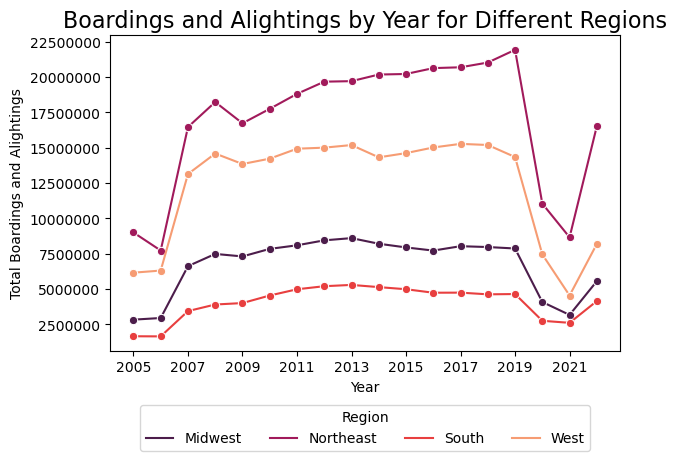

In [36]:
# State-to-region mapping (covering all US states) for better visual interpretation
state_to_region = {
    'CA': 'West', 'OR': 'West', 'WA': 'West', 'NV': 'West', 'UT': 'West', 'AZ': 'West', 'CO': 'West', 'ID': 'West', 
    'MT': 'West', 'WY': 'West', 'NM': 'West', 'AK': 'West', 'HI': 'West',
    'NY': 'Northeast', 'NJ': 'Northeast', 'MA': 'Northeast', 'CT': 'Northeast', 'RI': 'Northeast', 
    'VT': 'Northeast', 'NH': 'Northeast', 'ME': 'Northeast',
    'TX': 'South', 'FL': 'South', 'GA': 'South', 'NC': 'South', 'SC': 'South', 
    'VA': 'South', 'WV': 'South', 'AL': 'South', 'MS': 'South', 'TN': 'South', 
    'KY': 'South', 'AR': 'South', 'LA': 'South', 'OK': 'South',
    'IL': 'Midwest', 'OH': 'Midwest', 'MI': 'Midwest', 'IN': 'Midwest', 
    'WI': 'Midwest', 'MN': 'Midwest', 'IA': 'Midwest', 'MO': 'Midwest', 
    'ND': 'Midwest', 'SD': 'Midwest', 'KS': 'Midwest', 'NE': 'Midwest'
}

# Add a new 'region' column to the DataFrame based on the state_abbrev
state_groupings['region'] = state_groupings['state_abbrev'].map(state_to_region)

# Group by region and fiscal year, summing boardings_and_alightings
region_grouped = state_groupings.groupby(['region', 'fiscal_year'], as_index=False)['boardings_and_alightings'].sum()

# Create the plot with one line per region
sns.lineplot(data=region_grouped, x='fiscal_year', y='boardings_and_alightings', 
             hue='region', marker='o', palette='rocket')

# Add title and labels
plt.title('Boardings and Alightings by Year for Different Regions',fontsize=16)
plt.xlabel('Year')
plt.ylabel('Total Boardings and Alightings')

# Keep y-axis number format plain
plt.ticklabel_format(style='plain', axis='y')

# Set x-ticks to show every 2 years
year_range = region_grouped['fiscal_year'].unique()
plt.xticks(year_range[::2])

# legend
plt.legend(title='Region', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=4)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

#### Look at daily round trips to answer second part of question

Text(0.5, 1.0, 'Daily Round Trips by Route from 2020-2023')

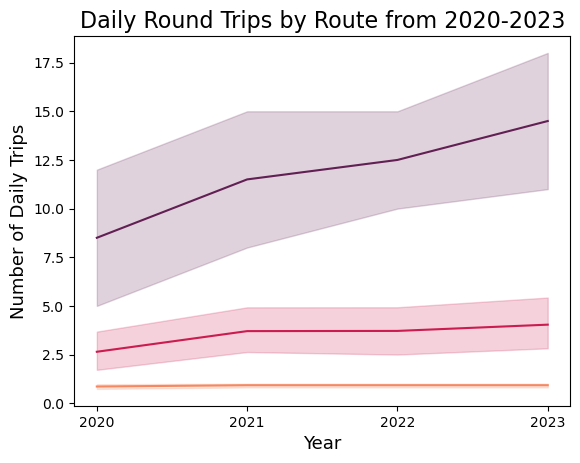

In [38]:
#create altered df for plotting
fy_roundtrips_plot = fy_roundtrips[["system", "route_name", "ave_weekday_rt_30_sept_2020","ave_weekday_rt_30_sept_2021", "ave_weekday_rt_30_sept_2022", "ave_weekday_rt_30_sept_2023"]]
fy_roundtrips_plot.rename(columns = {"system":"system",
                                     "route_name":"route_name",
                                    "ave_weekday_rt_30_sept_2020":"2020",
                                    "ave_weekday_rt_30_sept_2021" :"2021",
                                    "ave_weekday_rt_30_sept_2022" : "2022",
                                   "ave_weekday_rt_30_sept_2023" : "2023" }, inplace = True)
fy_roundtrips_plot = fy_roundtrips_plot.melt(id_vars=['route_name', 'system'], var_name='year', value_name='daily_trips')
sns.lineplot(data=fy_roundtrips_plot, x='year', y='daily_trips', hue='system', palette = 'rocket')
plt.xlabel('Year', fontsize=13)
plt.legend([], [], frameon=False)
plt.ylabel('Number of Daily Trips', fontsize=13)
plt.title('Daily Round Trips by Route from 2020-2023', fontsize=16)

In [39]:
#what % increase has daily round trips had from 2020 - 2023 by system? 
year_roundtrip_totals =fy_roundtrips_plot.groupby(['system', 'year'])['daily_trips'].sum().unstack(fill_value=0)
year_roundtrip_totals = round(year_roundtrip_totals,3)


In [40]:
#create dataframe to show % increase per year in daily round trips
year_roundtrip_increase = year_roundtrip_totals[["2021","2022","2023"]]
year_roundtrip_increase.rename(columns = {"2021":"2020 - 2021",
                                          "2022":"2021 - 2022",
                                          "2023":"2022 - 2023"}, inplace=True)
#change values
year_roundtrip_increase.iloc[0,0] = (year_roundtrip_totals.iloc[0,1]/year_roundtrip_totals.iloc[0,0]) - 1
year_roundtrip_increase.iloc[0,1] = (year_roundtrip_totals.iloc[0,2]/year_roundtrip_totals.iloc[0,1]) - 1
year_roundtrip_increase.iloc[0,2] = (year_roundtrip_totals.iloc[0,3]/year_roundtrip_totals.iloc[0,2]) - 1
year_roundtrip_increase.iloc[1,0] = (year_roundtrip_totals.iloc[1,1]/year_roundtrip_totals.iloc[1,0]) - 1
year_roundtrip_increase.iloc[1,1] = (year_roundtrip_totals.iloc[1,2]/year_roundtrip_totals.iloc[1,1]) - 1
year_roundtrip_increase.iloc[1,2] = (year_roundtrip_totals.iloc[1,3]/year_roundtrip_totals.iloc[1,2]) - 1
year_roundtrip_increase.iloc[2,0] = (year_roundtrip_totals.iloc[2,1]/year_roundtrip_totals.iloc[2,0]) - 1
year_roundtrip_increase.iloc[2,1] = (year_roundtrip_totals.iloc[2,2]/year_roundtrip_totals.iloc[2,1]) - 1
year_roundtrip_increase.iloc[2,2] = (year_roundtrip_totals.iloc[2,3]/year_roundtrip_totals.iloc[2,2]) - 1
year_roundtrip_increase = round(year_roundtrip_increase * 100,3)
year_roundtrip_increase = year_roundtrip_increase.astype(str) + '%'

In [41]:
year_roundtrip_increase = pd.DataFrame(year_roundtrip_increase)
year_roundtrip_increase

year,2020 - 2021,2021 - 2022,2022 - 2023
system,,,
Long Distance,7.778%,0.0%,0.0%
Northeast Corridor,35.294%,8.696%,16.0%
State Supported,35.135%,4.0%,8.654%
